# Steps of Statistical Analysis of Binary Structural Topology Measures with Iowa Gambling Task Performance

### 1. Distribution and Correlation Matrices

### 2. Principal Component Analysis (PCA)

### 3. Principal Component Regression (PCR)

### 4. Generalized Linear Model and Cross-Validation Analysis


# 1. Distribution and Correlation Matrices

## Distribution of Binary Structural Topology Measures 

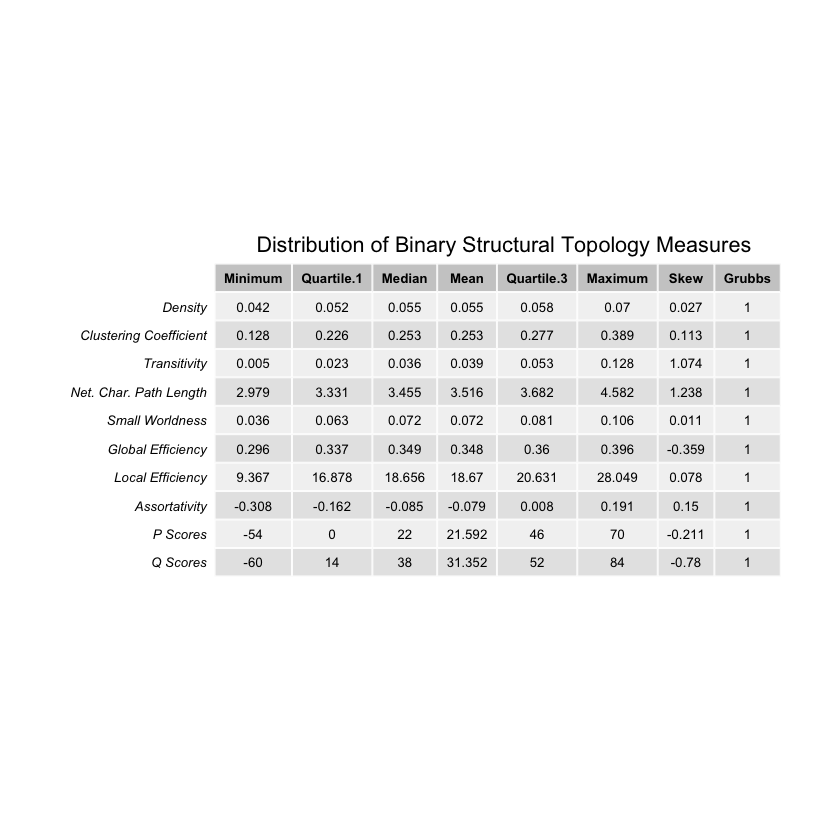

In [21]:
library(gridExtra)
library(grid)
library(outliers)
library(psych)

mergedWINData = read.csv(file="mergedWINData.csv")
mergedWINData$X = NULL

binaryVariables <- mergedWINData[,c(2,3,4,6,8,10,16,18,46,47)]

myWINDataAnalysisFrame <- t(do.call(cbind, lapply(binaryVariables, summary)))

myWINDataAnalysisFrame <- myWINDataAnalysisFrame[,-7] # removing last column (NA's count)

# skew(mergedWINData$density_baseline)
# skew(mergedWINData$clustering_coeff_average.binary._baseline)
# skew(mergedWINData$transitivity.binary._baseline)
# skew(mergedWINData$network_characteristic_path_length.binary._baseline)
# skew(mergedWINData$small.worldness.binary._baseline)
# skew(mergedWINData$global_efficiency.binary._baseline)
# skew(mergedWINData$local_efficiency.binary._baseline)
# skew(mergedWINData$assortativity_coefficient.binary._baseline)
# skew(mergedWINData$baseline_p)
# skew(mergedWINData$baseline_q)

skewValues <- c(0.02684528,0.1126648,1.073562, 1.237727,0.01113487,
                -0.3591412,0.07801355,0.1502269,-0.2112031,-0.779505)

myWINDataAnalysisFrame <- cbind(myWINDataAnalysisFrame,Skew = skewValues)

# grubbs.test(mergedWINData$density_baseline)
# grubbs.test(mergedWINData$clustering_coeff_average.binary._baseline)
# grubbs.test(mergedWINData$transitivity.binary._baseline)
# grubbs.test(mergedWINData$network_characteristic_path_length.binary._baseline)
# grubbs.test(mergedWINData$small.worldness.binary._baseline)
# grubbs.test(mergedWINData$global_efficiency.binary._baseline)
# grubbs.test(mergedWINData$local_efficiency.binary._baseline)
# grubbs.test(mergedWINData$assortativity_coefficient.binary._baseline)
# grubbs.test(mergedWINData$baseline_p)
# grubbs.test(mergedWINData$baseline_q)

grubbsTestOutliers <- c(1,1,1,1,1,1,1,1,1,1)

myWINDataAnalysisFrame <- cbind(myWINDataAnalysisFrame, Grubbs = grubbsTestOutliers)

colnames(myWINDataAnalysisFrame) <- c("Minimum", "Quartile 1", "Median", "Mean", 
                                      "Quartile 3", "Maximum", "Skew", "Grubbs")

rownames(myWINDataAnalysisFrame) <- c("Density", "Clustering Coefficient", "Transitivity", 
                                      "Net. Char. Path Length","Small Worldness", 
                                      "Global Efficiency", "Local Efficiency", 
                                      "Assortativity", "P Scores", "Q Scores")



myDataFrame <- data.frame(round(myWINDataAnalysisFrame, digits = 3))

myTheme <- ttheme_default(base_size = 8, base_colour = "black")

grid.table(myDataFrame, theme = myTheme)

grid.draw(textGrob("Distribution of Binary Structural Topology Measures", 
                   gp = gpar(fontsize = 13), x = unit(0.6, "npc"), y = unit(0.71, "npc")))



#### Analysis: The distribution of binary structural topology measures, also known as variables, has skewness, and is not normally distributed. Transitivity, Network Characteristic Path Length, and Q scores have the greatest amount of skewness calculated with 1.074, 1.238, and -0.780, respectively. With the Grubb's test for calculating outliers, all of the variables had a total of 1 outlier.   

### Correlation Matrix for Binary Structural Topology Measures

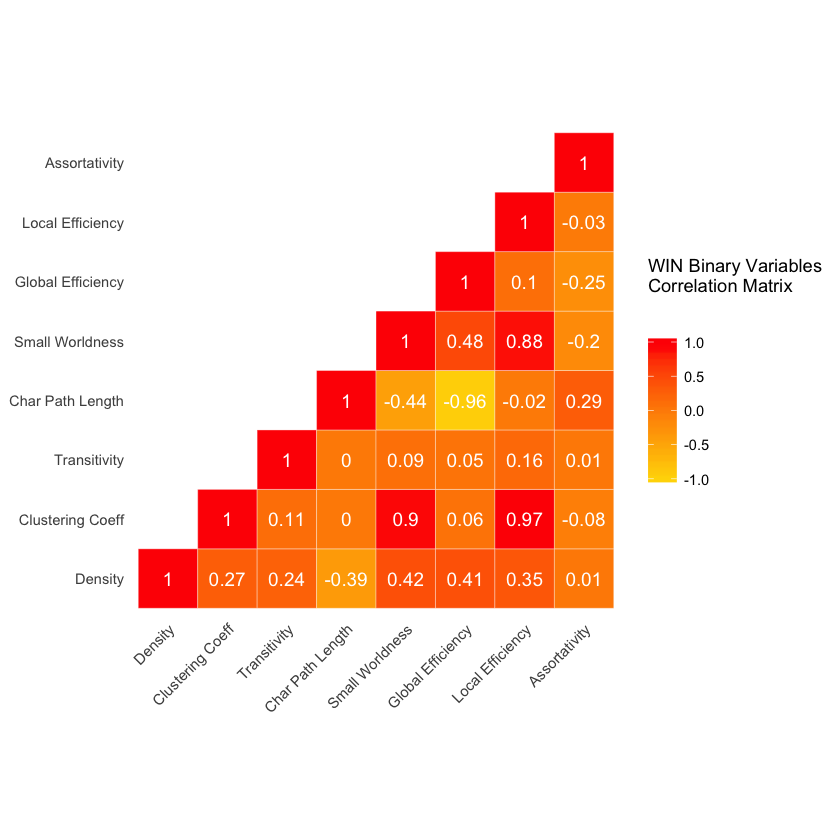

In [20]:
library(reshape2)
library(ggplot2)

#Selecting Binary Structural Topology Measures
myData <- mergedWINData[1:126, c(2,3,4,6,8,10,16,18)]

#Making a Correlation Matrix
corrMatrix <- round(cor(myData, use="complete.obs"), 2)

#Only keeping the lower half of the matrix
getLowerTri <- function(corrMatrix){
  corrMatrix[upper.tri(corrMatrix)] <- NA
  return(corrMatrix)}
lowerTri <- getLowerTri(corrMatrix)
meltedCorrMatrix <- melt(lowerTri, na.rm = TRUE )

#Plotting the Correlation Matrix and the plot characteristics
ggplot(data = meltedCorrMatrix, p.mat = p.mat, aes(x=Var1, y=Var2, fill=value)) + 
  
  geom_tile(color="white") +
  
  scale_x_discrete(labels = c("Density", "Clustering Coeff", "Transitivity", "Char Path Length", 
                            "Small Worldness", "Global Efficiency", "Local Efficiency", 
                            "Assortativity")) +
  
  scale_y_discrete(labels = c("Density", "Clustering Coeff", "Transitivity", "Char Path Length", 
                            "Small Worldness", "Global Efficiency", "Local Efficiency", 
                            "Assortativity")) +
  
  scale_fill_gradient(low = "gold", high = "red", 
                      limit = c(-1,1), space = "Lab",
                      name = "WIN Binary Variables\nCorrelation Matrix\n\n") + 
  theme_minimal() + 
  
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank(),
    axis.ticks = element_blank(),
    axis.text.x = element_text(angle = 45, vjust = 1, size = 9, hjust = 1)) +
  
  coord_fixed() +
  
  geom_text(aes(Var1, Var2, label = value), color = "white", size = 4)


Analysis: The correlation matrix demonstrates that there are many correlations between the binary structural topology measures. Correlations with absolute value greater or equal to 0.4 are considered high, because that is the threshold for the medium effect size. There were strong correlations between Density and Small Worldness, Density and Global Efficiency, Clustering Coefficient and Small Worldness, Clustering Coefficient and Local Efficiency, Network Characteristic Path Length and Small Worldness, and Network Characteristic Path Length and Global Efficiency, and Small Worldness and Global Efficiency, and Small Worldness and Local Efficiency. 

The greatest correlations observed were between Small Worldness and Local Efficiency with 0.88, Clustering Coefficient and Small Worldness with 0.90, and Clustering Coefficient and Local Efficiency with 0.97.

Strong correlations among the variables is evidence that they share the same variance. This is known as multicolinearity, which is a violation of the assumptions for regression. This requires Principal Component Analysis before calculating a Generalized Linear Model. 

# 2. Principal Component Analysis (PCA)

In [41]:
#Standardization of Structural Topology Measures
density_baseline_scaled <- scale(mergedWINData$density_baseline)
clustering_coeff_average.binary._baseline_scaled <- scale(mergedWINData$clustering_coeff_average.binary._baseline)
transitivity.binary._baseline_scaled <- scale(mergedWINData$transitivity.binary._baseline)
network_characteristic_path_length.binary._baseline_scaled <- scale(mergedWINData$network_characteristic_path_length.binary._baseline)
small.worldness.binary._baseline_scaled <- scale(mergedWINData$small.worldness.binary._baseline)
global_efficiency.binary._baseline_scaled <- scale(mergedWINData$global_efficiency.binary._baseline)
local_efficiency.binary._baseline_scaled <- scale(mergedWINData$local_efficiency.binary._baseline)
assortativity_coefficient.binary._baseline_scaled <- scale(mergedWINData$assortativity_coefficient.binary._baseline)


#Creating Data Frame of Standardized Variables
standardizedVariables <- data.frame(density=density_baseline_scaled,
                                    clust_binary=clustering_coeff_average.binary._baseline_scaled,
                                    trans_binary=transitivity.binary._baseline_scaled,
                                    net_binary=network_characteristic_path_length.binary._baseline_scaled,
                                    small_binary=small.worldness.binary._baseline_scaled,
                                    global_binary=global_efficiency.binary._baseline_scaled,
                                    local_binary=local_efficiency.binary._baseline_scaled,
                                    assort_binary=assortativity_coefficient.binary._baseline_scaled)



Importance of components:
                         Comp.1    Comp.2    Comp.3    Comp.4     Comp.5
Standard deviation     1.836647 1.4140841 1.0563707 0.9471558 0.73641242
Proportion of Variance 0.421659 0.2499542 0.1394899 0.1121380 0.06778791
Cumulative Proportion  0.421659 0.6716133 0.8111032 0.9232412 0.99102908
                            Comp.6     Comp.7       Comp.8
Standard deviation     0.223352263 0.13709880 0.0555430344
Proportion of Variance 0.006235779 0.00234951 0.0003856286
Cumulative Proportion  0.997264861 0.99961437 1.0000000000

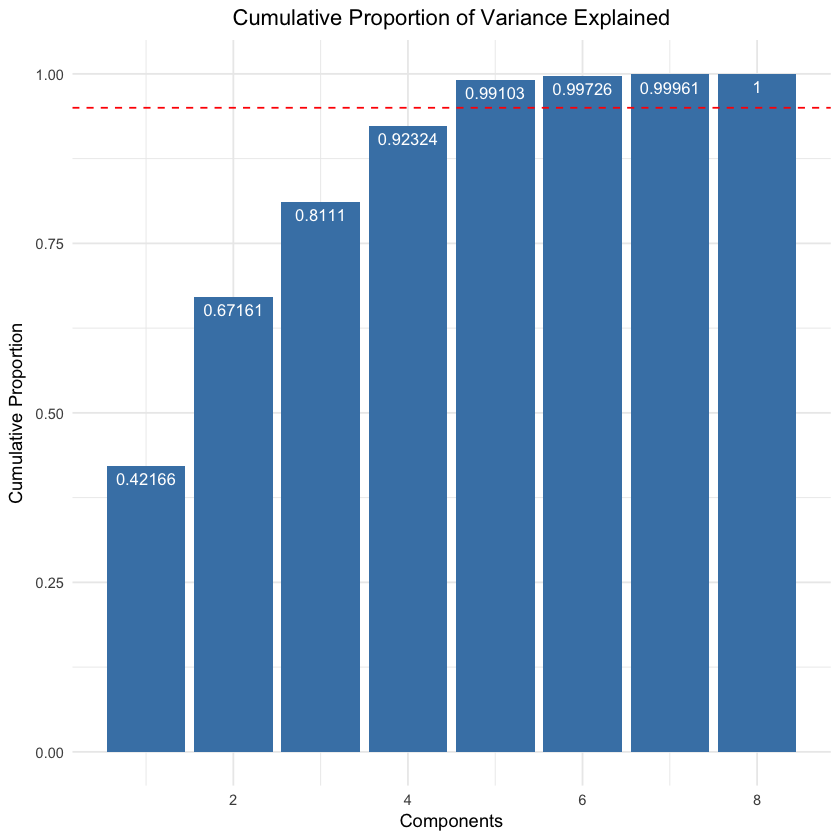

In [42]:
library("factoextra")

myData <- standardizedVariables

myPCA = princomp(na.omit(myData),
               cor = TRUE,
               scores = TRUE)

summary(myPCA)

myValues <- c(0.421659, 0.6716133, 0.8111032, 0.9232412, 0.99102908, 0.997264861, 0.99961437, 1.0000000000)
myComponents <- c(1,2,3,4,5,6,7,8)

myData <- data.frame(myComponents, myValues)

ggplot(myData, aes(x=myComponents, y=myValues)) +
  geom_bar(stat="identity", fill="steelblue") + 
    geom_text(aes(label=round(myValues, digits=5)), vjust=1.6, color="white", size=3.5)+
        theme_minimal() +
            labs(x="Components", y = "Cumulative Proportion") +
                ggtitle("Cumulative Proportion of Variance Explained") +
                    theme(plot.title = element_text(hjust = 0.5)) +
                        geom_hline(yintercept=.95,linetype="dashed", color = "red")

Analysis: The PCA Cummulative Proportion of Variance Explained plot demonstrates that the first 5 components optimally account for the variance among the variables. The plot also shows that the cummulative proportion of variance accounted by the first 5 components is 99.102908 %. This suggests that the first 5 principal components should be used when making a model that can predict for P or Q scores.


# Interlude: Make a function for doing cross validation to use later.

In [23]:
kfcv.sizes = function(n, k=10) {
  # generate sample sizes for k-fold cross validation on a data set of
  # size n
  
  # author: Matthias C. M. Troffaes
  # date: 22 Nov 2010
  # license: GPLv3
  # usage:
  #
  #   kfcv.sizes(n, k=...)
  #

  sizes = c()
  for (i in 1:k) {
    first = 1 + (((i - 1) * n) %/% k)
    last = ((i * n) %/% k)
    sizes = append(sizes, last - first + 1)
  }
  sizes
}

kfcv.testing = function(n, k=10) {
  # generate testing sample indices for k-fold cross validation on a
  # data set of size n
  
  # author: Matthias C. M. Troffaes
  # date: 22 Nov 2010
  # license: GPLv3
  # usage:
  #
  #   kfcv.testing(n, k=...)
  #

  indices = list()
  sizes = kfcv.sizes(n, k=k)
  values = 1:n
  for (i in 1:k) {
    # take a random sample of given size
    s = sample(values, sizes[i])
    # append random sample to list of indices
    indices[[i]] = s
    # remove sample from values
    values = setdiff(values, s)
  }
  indices
}


# 3. Principal Component Regression (PCR)

## With P Score

In [152]:
#install.packages("pls")
library(pls)

#PCR Calculation
pcr.fit = pcr(baseline_p_scaled~
           density_baseline_scaled+
           clustering_coeff_average.binary._baseline_scaled+
           transitivity.binary._baseline_scaled+
           network_characteristic_path_length.binary._baseline_scaled+
           small.worldness.binary._baseline_scaled+
           global_efficiency.binary._baseline_scaled+
           local_efficiency.binary._baseline_scaled+
           assortativity_coefficient.binary._baseline_scaled,
          data = standardizedVariables,
          scale = TRUE,
          validation = "CV"
           )


#Summary Output
summary(pcr.fit)

#Validation Plot
validationplot(pcr.fit, val.type = "MSEP")
predplot(pcr.fit)
coefplot(pcr.fit)

ERROR: Error in model.frame.default(formula = p_filtered ~ density_baseline_scaled + : variable lengths differ (found for 'density_baseline_scaled')


Analysis: The PCR Mean Squared Error of Prediction plot shows that the first 1 principal components optimally account for the variability in 1 scores, or can predict the P score accurately. The first 5 principal components explain 99.103 % of the variance in P scores. This analysis states that 5 principal components should be used in the model to predict P scores. 
*plot AIC (or BIC) instead

## With Q Score

Data: 	X dimension: 124 8 
	Y dimension: 124 1
Fit method: svdpc
Number of components considered: 8

VALIDATION: RMSEP
Cross-validated using 124 leave-one-out segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           1.008    1.015    1.016    1.015    1.018    1.012    1.019
adjCV        1.008    1.014    1.016    1.015    1.018    1.012    1.018
       7 comps  8 comps
CV       1.021    1.024
adjCV    1.021    1.023

TRAINING: % variance explained
                   1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
X                  42.1659   67.161   81.110   92.324   99.103   99.726
baseline_q_scaled   0.2339    1.409    2.983    3.864    7.483    7.688
                   7 comps  8 comps
X                   99.961   100.00
baseline_q_scaled    9.091    10.09


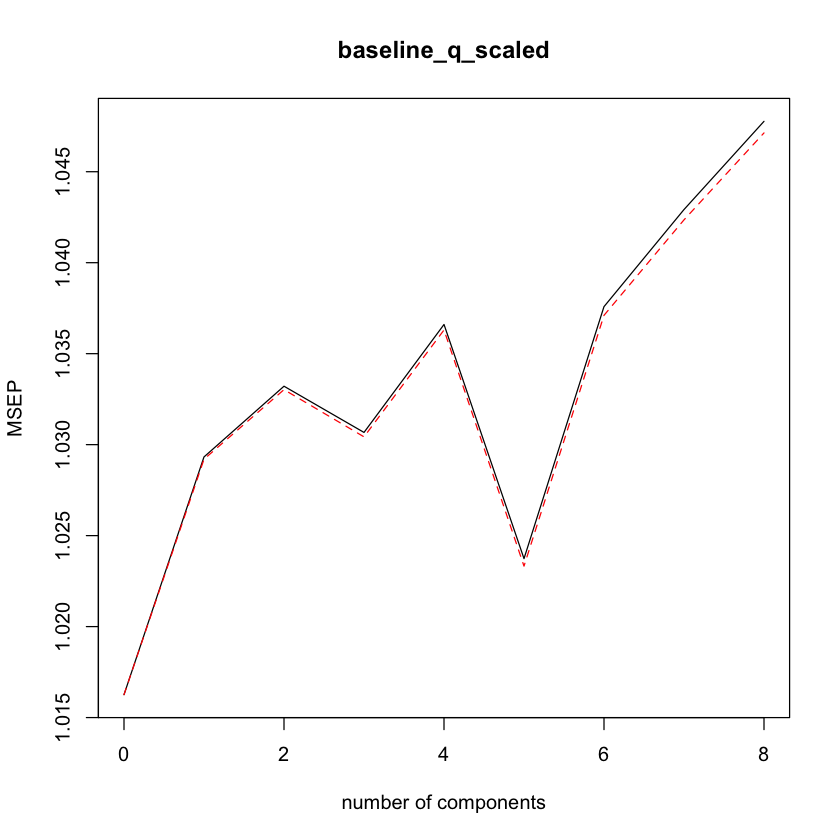

In [28]:
#PCR Calculation
pcr.fit = pcr(baseline_q_scaled~
           density_baseline_scaled+
           clustering_coeff_average.binary._baseline_scaled+
           transitivity.binary._baseline_scaled+
           network_characteristic_path_length.binary._baseline_scaled+
           small.worldness.binary._baseline_scaled+
           global_efficiency.binary._baseline_scaled+
           local_efficiency.binary._baseline_scaled+
           assortativity_coefficient.binary._baseline_scaled,
          data = standardizedVariables,
          scale = TRUE,
          validation = "LOO"
           )

#Summary Output
summary(pcr.fit)

#Validation Plot
validationplot(pcr.fit, val.type = "MSEP")

Analysis: The PCR Mean Squared Error of Prediction plot shows that the first 5 principal components optimally account for the variability in Q scores, or can predict the Q score accurately. The first 5 principal components explain 99.103 % of the variance in Q scores. This analysis states that 5 principal components should be used in the model to predict Q scores. 

# 4. Generalized Linear Model and Cross-Validation Analysis

## With P Score

[1] 0.2452041

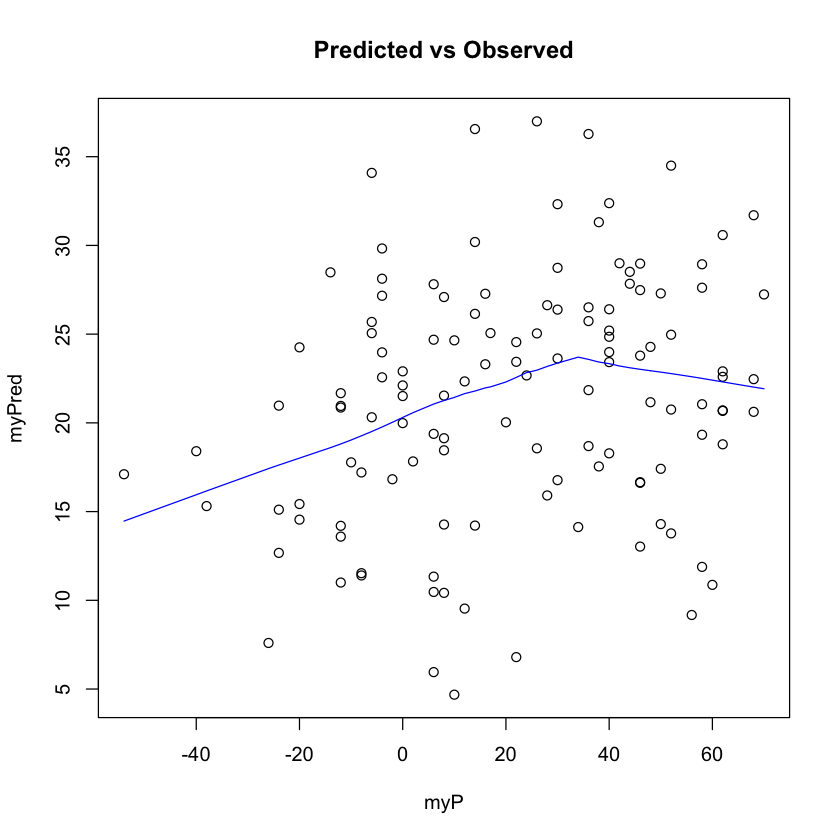

In [153]:
library(MASS)
library(boot)
library(glmnet)

#Principal Component Calculation
myData <- standardizedVariables[,c(1,2,3,4,5,6,7,8)]
myPCA <- princomp(na.omit(myData), cor = TRUE, scores = TRUE)
myComponents <- myPCA$scores[, 1:5]

#Fixing P Score Length
myP <- mergedWINData$baseline_p[setdiff(1:126,c(118,126))]


#Combining both lists into one data.frame
myComboData <- data.frame(myPCA$scores[, 1:5], baseline_p_scaled[1:124, ])

#GLM Calculation
myFit <- glm(myP~myComponents, family= gaussian, data=myComboData)

myPred <- myFit$fitted.values

plot(myP, myPred, main="Predicted vs Observed")
lines(lowess(myP, myPred), col="blue")
cor(myP, myPred)


#CV Calculation (to remove later)

myCV <- cv.glmnet(y = myP, x=myPCA$scores[,1:5], family="gaussian")
lmin <- myCV$lambda.min
pred <- predict(myCV$glmnet.fit, s = lmin, type="nonzero")
#myCV$delta


In [ ]:
myCV$glmnet.fit

Analysis: The GLM with the P scores and the top 5 principal components produces predicts P scores with 0.2113312 correlation with the actually observed P scores given the 5 principal components. The cross validation errors calculated from the GLM are 1.026819 and 1.026819, which are significantly low values.

## With Q Score

[1] 0.2749978

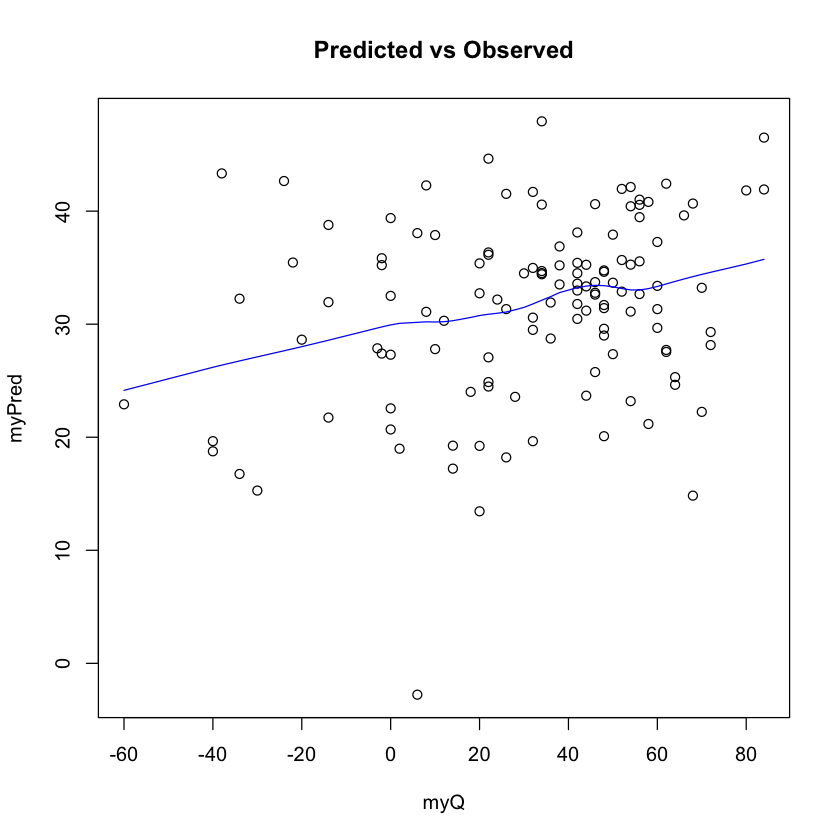

In [154]:
library(MASS)
library(boot)

#Principal Component Calculation
myData <- standardizedVariables[,c(1,2,3,4,5,6,7,8)]
myPCA <- princomp(na.omit(myData), cor = TRUE, scores = TRUE)
myComponents <- myPCA$scores[, 1:5]

#Fixing Q Score Length
myQ <- mergedWINData$baseline_q[setdiff(1:126,c(118,126))]


#Combining both lists into one data.frame
myComboData <- data.frame(myPCA$scores[, 1:5], baseline_q_scaled[1:124, ])

#GLM Calculation
myFit <- glm(myQ~myComponents, family= gaussian, data=myComboData)

myPred <- myFit$fitted.values

plot(myQ, myPred, main="Predicted vs Observed")
lines(lowess(myQ, myPred), col="blue")
cor(myQ, myPred)

#CV Calculation
#myCV <- cv.glm(myComboData, myFit)
#myCV$delta

Analysis: The GLM with the Q scores and the top 5 principal components produces predicts Q scores with 0.2672334 correlation with the actually observed Q scores given the 5 principal components. The cross validation errors calculated from the GLM are 1.061468 and 1.061468, which is significantly low value.

# 4. Cross validation of the PCR analysis looking at hold out set reliability (for P & Q)

-0.19354244
-0.27501559
-0.12480436
-0.18520705
0.13930918
-0.06900699
-0.03449027
-0.02886199
0.01138042
-0.20614548


[1] 21.5074666  1.8297414  2.8521067  0.6249968 -3.4692060  3.4208578

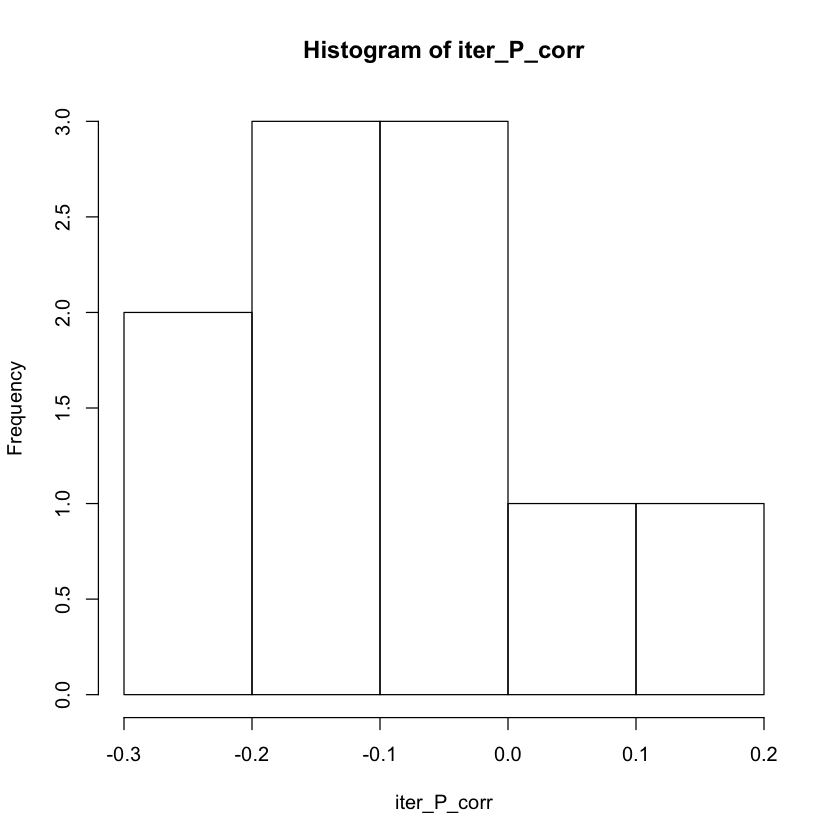

In [170]:
#Principal Component Calculation

# Turn off warnings
options(warn=-1)

# Define number of folds
n_folds = 124

# Define number of resamples
n_iter = 10

store_P_predictions = matrix(0,124,n_iter)
store_P_coef = matrix(0,n_iter, 6)
iter_P_corr = matrix(0,n_iter,1)

for (iter in 1:n_iter) {
    
    # Make our 10 fold cross validation indices
    indices = kfcv.testing(124, k=n_folds)
    
    PredP = matrix(0,124,1)
    CVPCoefs = matrix(0,n_folds,6)

    for (fold in 1:n_folds) {
        test = unlist(indices[fold])
        train = unlist(indices[setdiff(1:n_folds, fold)])

        cvfit <- glm(myP~myComponents, data=myComboData, subset=train)
        PredP[test] = predict(cvfit, data=myComboData, subset=test)
        CVPCoefs[fold,] = coef(cvfit)

    }
    
    iter_P_corr[iter] = cor(myP, PredP)

    store_P_predictions[,iter] = PredP
    store_P_coef[iter,] = colMeans(CVPCoefs)
}
    
hist(iter_P_corr)

iter_P_corr

PModelCoefs = colMeans(store_P_coef)
PModelCoefs

[1] 31.5082120 -0.8318012  2.2952562 -3.2527525  3.1941700  7.5292195

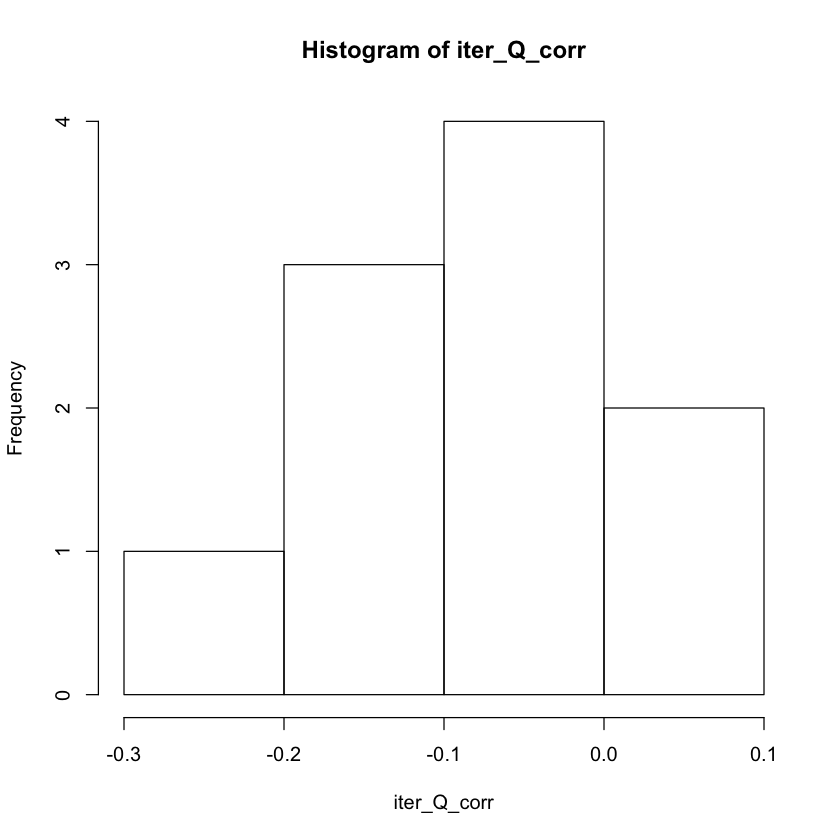

In [159]:
#Principal Component Calculation

store_Q_predictions = matrix(0,124,n_iter)
store_Q_coef = matrix(0,n_iter, 6)
iter_Q_corr = matrix(0,n_iter,1)

for (iter in 1:n_iter) {
    
    # Make our k fold cross validation indices
    indices = kfcv.testing(124, k=n_folds)
    
    PredQ = matrix(0,124,1)
    CVQCoefs = matrix(0,n_folds,6)

    for (fold in 1:n_folds) {
        test = unlist(indices[fold])
        train = unlist(indices[setdiff(1:n_folds, fold)])

        cvfit <- glm(myQ~myComponents, family=gaussian, data=myComboData, subset=train)
        PredQ[test] = predict(cvfit, data=myComboData, subset=test)
        CVQCoefs[fold,] = coef(cvfit)

    }
    
    iter_Q_corr[iter] = cor(myQ, PredQ)

    store_Q_predictions[,iter] = PredQ
    store_Q_coef[iter,] = colMeans(CVQCoefs)
}
    
hist(iter_Q_corr)


QModelCoefs = colMeans(store_Q_coef)
QModelCoefs


In [74]:
# Get the matrix to transform back to data space
V = myPCA$loadings

# The weight (or influence) of each term on P
wP = V %*% c(PModelCoefs[2:6],0,0,0)
wP

density,3.24555834
clust_binary,-1.05709585
trans_binary,-0.50197954
net_binary,-1.87820018
small_binary,-0.08881281
global_binary,1.68270042
local_binary,-0.83694692
assort_binary,-1.12682756


In [ ]:

# The weight (or influence) of each term on P
wQ = V %*% c(QModelCoefs[2:6],0,0,0)
wQ

# Now run an inference test, instead of a prediction test.

In [180]:
# Take all of the princial components
allPCs = myPCA$scores

# Learn the GLM for P
#Combining both lists into one data.frame
#myComboData <- data.frame(myPCA$scores, myP)
P.fit = glm(myP~myPCA$scores)
summary(P.fit)



Call:
glm(formula = myP ~ myPCA$scores)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-70.847  -21.390    0.561   20.553   49.267  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         21.41129    2.50801   8.537 6.49e-14 ***
myPCA$scoresComp.1   1.86447    1.36554   1.365    0.175    
myPCA$scoresComp.2   2.86174    1.77359   1.614    0.109    
myPCA$scoresComp.3   0.54645    2.37417   0.230    0.818    
myPCA$scoresComp.4  -3.56099    2.64794  -1.345    0.181    
myPCA$scoresComp.5   3.50806    3.40571   1.030    0.305    
myPCA$scoresComp.6  -0.02504   11.22894  -0.002    0.998    
myPCA$scoresComp.7  -7.03662   18.29344  -0.385    0.701    
myPCA$scoresComp.8 -27.69808   45.15434  -0.613    0.541    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 779.9735)

    Null deviance: 95870  on 123  degrees of freedom
Residual deviance: 89697  on 115  

In [181]:
Q.fit = glm(myQ~myPCA$scores)
summary(Q.fit)


Call:
glm(formula = myQ ~ myPCA$scores)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-81.48  -18.01    7.05   18.09   57.42  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         31.4435     2.5888  12.146   <2e-16 ***
myPCA$scoresComp.1  -0.8115     1.4095  -0.576    0.566    
myPCA$scoresComp.2   2.3042     1.8307   1.259    0.211    
myPCA$scoresComp.3  -3.3657     2.4506  -1.373    0.172    
myPCA$scoresComp.4   3.2308     2.7332   1.182    0.240    
myPCA$scoresComp.5   7.4597     3.5154   2.122    0.036 *  
myPCA$scoresComp.6   6.1597    11.5905   0.531    0.596    
myPCA$scoresComp.7  26.2836    18.8825   1.392    0.167    
myPCA$scoresComp.8  54.6115    46.6083   1.172    0.244    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 831.011)

    Null deviance: 106615  on 123  degrees of freedom
Residual deviance:  95566  on 115  degrees of freedom


In [189]:
Qcoefs = coef(Q.fit)
Qcoefs[1:5]=0;
Qcoefs[7:9]=0;
Qcoefs

wQ = V %*% Qcoefs[2:9]
wQ

(Intercept) myPCA$scoresComp.1 myPCA$scoresComp.2 myPCA$scoresComp.3 
          0.000000           0.000000           0.000000           0.000000 
myPCA$scoresComp.4 myPCA$scoresComp.5 myPCA$scoresComp.6 myPCA$scoresComp.7 
          0.000000           7.459704           0.000000           0.000000 
myPCA$scoresComp.8 
          0.000000

density,5.8886628
clust_binary,-0.4625534
trans_binary,-2.4370624
net_binary,1.5614702
small_binary,-1.0106807
global_binary,-2.0043067
local_binary,-0.2792635
assort_binary,-2.6949413
